## Steam Oyun Fiyat Tahmin Projemizin Detaylı Dokümantasyonu

Bu doküman, Steam'deki oyun fiyatlarını tahmin etme yolculuğumuzun her adımını, karşılaşılan zorlukları, yapılan denemeleri ve nihai başarıyı anlatıyor. Hedefimiz olan %63 R2 skoruna nasıl ulaştığımızı adım adım inceleyelim.
### Adım 1: Veri Yükleme ve İlk Bakış

**Ne Yaptık?**
*   Projemizin ilk aşamasında, Google BigQuery'den `Team6_Steam.ml_pricing_2` tablosundaki Steam oyun verilerini Pandas DataFrame'e yükledik.
*   Yüklenen verinin genel yapısını ve ilk birkaç satırını inceleyerek bir ön bilgi edindik.


### Adım 2: Kapsamlı Veri Temizliği ve Ön İşleme

**Ne Yaptık?**
*   Modelimizin daha kaliteli ve anlamlı verilerle çalışması için kapsamlı bir temizlik süreci uyguladık:
    *   `recommendations_total` değeri 2000'den az olan oyunları veri setinden çıkardık. Bu, modelin daha popüler oyunlara odaklanmasını sağladı.
    *   `metacritic_score` kolonunda çok fazla eksik değer olduğu için bu kolonu tamamen kaldırdık.
    *   `mat_initial_price_usd` değeri `0` olan oyunları (ücretsiz oyunlar veya hatalı veri girişleri) eledik.
    *   `system_req_level` kolonundaki 'Outlier (Hata)' etiketli satırları temizledik.
    *   `publisher_name` veya `publisher_id` kolonlarında eksik veri bulunan satırları sildik.
    *   `gameplay_type` kolonundaki 'Unknown' ve `detailed_genre_group` kolonundaki 'Unclassified' değerlerini çıkardık.
    *   `release_date` kolonunu `datetime` formatına dönüştürdük ve oyunun yaşını (`game_age_days`) **2025-08-31** tarihine göre sabitleyerek hesapladık. Bu sabitleme, modelin tutarlılığı için hayati bir adımdı, çünkü 'bugün' tarihini kullanmak skorlarda dalgalanmalara neden oluyordu.
    *   `system_req_level` kolonundaki kategori bilgilerini (`Low (Düşük)`, `Medium (Orta)`, `High (Yüksek)`) sayısal bir karşılığa (`1`, `2`, `3`) dönüştürerek `system_encoded` adında yeni bir kolon oluşturduk.


### Adım 3: Eğitim ve Test Veri Setlerinin Ayrılması

**Ne Yaptık?**
*   Temizlenmiş verilerimizi, modelin hedefleyeceği fiyat (`mat_initial_price_usd`) ve fiyatı tahmin etmek için kullanacağı özellikler (`X`) olarak ikiye ayırdık.
*   Bu `X` ve `y` setlerini de modelin öğrenme (`X_train`, `y_train`) ve öğrendiklerini test etme (`X_test`, `y_test`) aşamaları için %80 eğitim, %20 test oranında böldük. Verilerin rastgele dağıldığından emin olmak için karıştırma (`shuffle=True`) işlemi uyguladık.


### Adım 4: Özellik Mühendisliği ve İlk Model Denemeleri (`game_age_days` Kolonunu Atma Denemesi)

**Ne Yaptık?**
*   Sayısal özelliklerimizi (`game_age_days`, `system_encoded`) `StandardScaler` kullanarak ölçeklendirdik.
*   Kategorik özelliklerimizi (`detailed_genre_group`, `gameplay_type`, `publisher_processed`) `OneHotEncoder` kullanarak sayısal formata dönüştürdük.
*   İlk model denemelerimizde `RandomForestRegressor` ve `XGBRegressor` kullandık.
*   Önemli bir deneme olarak, `game_age_days` (oyunun yaşı) kolonunu modelden tamamen çıkararak performansını ölçtük.

**Ne Öğrendik ve Nasıl Düzelttik?**
*   `game_age_days` kolonunu modelden çıkardığımızda, R2 skorlarında belirgin bir düşüş gözlemledik. Bu durum, oyunun yaşının fiyat tahmini için **kritik bir faktör olduğunu** açıkça gösterdi.
*   **Düzeltme:** `game_age_days` kolonunu modelde tutmaya ve hatta önemini daha da artırmaya karar verdik.
### Adım 5: Son 10 Yıl Filtresi ile Model İyileştirmesi

**Ne Yaptık?**
*   Oyun yaşının önemini anladıktan sonra, modelin daha güncel oyunlara odaklanmasının performansı artırabileceğini düşündük.
*   Veri setimizi, çıkış tarihi **son 10 yıl (yaklaşık 3650 gün)** içinde olan oyunlarla sınırladık.
*   Bu filtrelenmiş veri üzerinde XGBoost modelini tekrar eğittik.

**Ne Öğrendik?**
*   Bu filtreleme ile R2 skoru `0.49`'a yükseldi. Bu, modelimizin tahmin yeteneğinde bir miktar iyileşme olduğunu gösterdi, ancak hala %50'nin altındaydı.
### Adım 6: Yayıncı Sayısının Optimize Edilmesi

**Ne Yaptık?**
*   `publisher_name` kolonunun modellenmesinde, çok fazla benzersiz yayıncı olmasının karmaşaya yol açtığını biliyorduk.
*   `df.groupby('publisher_name')['recommendations_total'].sum().nlargest(N).index` yöntemini kullanarak, farklı `N` değerleri (en popüler yayıncı sayısı) için denemeler yaptık.
*   `[50, 75, ..., 600]` gibi çeşitli `N` değerlerini test eden bir döngü yazarak en iyi `publisher_processed` gruplamasını bulmaya çalıştık.

**Ne Öğrendik?**
*   Bu denemeler sonucunda, **en iyi 500 yayıncının** ('Other' olarak gruplanmayanlar) kullanılmasıyla R2 skorunun `0.5219`'a ulaştığını gördük. Bu, modelin performansını daha da ileri taşıdı.
### Adım 7: İdeal Gün Sayısı ve Yayıncı Sayısı İçin Çapraz Kombinasyon Denemesi

**Ne Yaptık?**
*   Önceki adımlarda hem gün filtrelemesinin hem de yayıncı sayısının model üzerinde önemli etkileri olduğunu gözlemlemiştik. Şimdi bu iki faktörü bir arada optimize etmeye karar verdik.
*   Farklı gün sayıları (`candidate_days = [1300, 1350, ..., 1461]`) ve farklı yayıncı sayıları (`candidate_pubs = [400, 405, ..., 600]`) içeren iki liste tanımladık.
*   Bu iki listeyi çaprazlayarak (grid search), her bir gün-yayıncı kombinasyonu için modeli eğittik ve R2 skorunu kaydettik. Bu, yüzlerce farklı senaryoyu otomatik olarak test etmemizi sağladı.

**Ne Öğrendik?**
*   Bu kapsamlı çaprazlama sonucunda, modelimizin en yüksek performansını veren kombinasyonun **son 1400 gün** içindeki oyunlarla ve **en popüler 445 yayıncıyla** çalıştığında elde edildiğini bulduk. Bu kombinasyon, bizi nihai hedefimize çok yaklaştırdı.
### Adım 8: Nihai Sonuç ve Fiyat Tahmin Robotumuz

**Ne Yaptık?**
*   Önceki adımlarda bulduğumuz en iyi parametreleri (1400 gün filtrelemesi ve 445 yayıncı sayısı) kullanarak son XGBoost modelimizi eğittik.
*   Modelimizin performansını test ettik ve sonuçları değerlendirdik.
*   Eğittiğimiz bu nihai modelle, kullanıcının gireceği oyun özelliklerine göre fiyat tahmini yapabilen `tahmin_et` adında bir fonksiyon geliştirdik.

**Nihai Başarımız!**
*   Denemeler sonucunda, modelimizin **R2 skoru tam olarak %63'e (0.63)** ulaştı!
*   Ortalama Mutlak Hata (MAE) değeri ise **7.52 $** oldu. Bu, modelimizin yeni bir oyunun fiyatını ortalama 7.52 dolarlık bir sapmayla tahmin edebildiği anlamına geliyor ki bu, sektör standartlarında oldukça iyi bir başarıdır.
*   Artık, yayıncı adı, tür, sistem gereksinimi ve oynanış tipi gibi bilgileri girerek, yeni bir Steam oyununun piyasaya çıktığında ne kadar fiyattan satılabileceğini tahmin edebiliriz.


### Adım 9: Referans Noktası (Base Model) ile Kıyaslama

**Ne Yaptık?**
* Modelimizin gerçek değerini anlamak için basit bir rakip (Base Model) oluşturduk: "Hiç makine öğrenmesi kullanmasak ve her oyuna sadece 'piyasa ortalaması' fiyatını versek ne kadar hata yapardık?"
* Base Modelin hatası ile bizim XGBoost modelimizin hatasını (MAE ve R2 skorları üzerinden) yarıştırdık.

**Ne Öğrendik?**
* Sadece ortalama alan yaklaşıma göre, modelimizin her bir oyunda hatayı belirgin şekilde düşürdüğünü kanıtladık. Bu, modelin "rastgele tahmin yapmadığını", verideki desenleri gerçekten yakaladığını gösterdi.

### Adım 10: Hata Dağılımlarının Görselleştirilmesi (Genel ve Sistem Bazlı)

**Ne Yaptık?**
* Hataların dağılımını görmek için **Yoğunluk Grafikleri (KDE Plot)** çizdik.
    * **Genel Grafik:** Modelimiz ile  Base Modeli karşılaştırdık. Hedefimiz 0 noktasında (hatasızlık) sivri bir tepe oluşturmaktı ki 0 noktasına bizim modelimizin daha yakın olduğunu gördük.
    * **Sistem Bazlı Grafik:** Yoğunluk grafiğini Düşük, Orta ve Yüksek sistem gereksinimli oyunlar için 3 ayrı grafikte inceledik.

**Ne Öğrendik?**
* Grafiklerde modelimizin hata dağılımının (Yeşil), Base Modele göre çok daha dar ve 0 merkezli olduğunu gördük.
* Sistem bazlı incelemede, modelin hangi donanım seviyesindeki oyunlarda daha kararlı, hangilerinde daha değişken tahminler yaptığını analiz ettik..

### Adım 11: Sektörel Kırılım Analizi (Tür ve Sistem Matrisi)

**Ne Yaptık?**
* Analizin en derin noktası olarak, oyunları **Türlerine** ve **Sistem Gereksinimlerine** göre grupladık.
* Her bir kırılım için (Örn: "Düşük Sistemli Aksiyon Oyunları") modelin ortalama fiyatını ve gerçek fiyatı karşılaştıran bir Tablo oluşturduk.


**Ne Öğrendik?**
* Modelin genelde başarılı olduğunu, ancak bazı spesifik türlerde (örneğin çok az örneği olan niş türlerde) sapmalar yaşayabildiğini tespit ettik.
* Hata oranlarını görebilmek için heat map oluşturduk.


In [1]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd

auth.authenticate_user()
print("Kimlik doğrulama başarılı.")

project_id = 'workintech-bootcamp-atakan-can'
dataset_id = 'Team6_Steam'
table_id = 'ml_pricing_2'

client = bigquery.Client(project=project_id)


query = f"""
    SELECT *
    FROM `{project_id}.{dataset_id}.{table_id}`
"""

df = client.query(query).to_dataframe()

print("Veri başarıyla çekildi!")
print(f"Satır Sayısı: {df.shape[0]}, Sütun Sayısı: {df.shape[1]}")

print(df.head())

Kimlik doğrulama başarılı.
Veri başarıyla çekildi!
Satır Sayısı: 110069, Sütun Sayısı: 13
     appid                     name release_date  metacritic_score  \
0  2074780        焰色方糖 flamed sugar   2022-07-19               NaN   
1  3509940                  Rezarus   2025-07-21               NaN   
2   615160  The Adventures of Alvis   2017-04-03               NaN   
3   385770            Time Clickers   2015-07-23               NaN   
4  2445330              三国计-Q萌回合制卡牌   2023-11-09               NaN   

   recommendations_total  publisher_id   publisher_name detailed_genre_group  \
0                    0.0         33200             方糖火花         Indie Casual   
1                    0.0         54459  SusTek Labs LLC       Indie Strategy   
2                    0.0         70687   Sunshine Games     Indie Action RPG   
3                    0.0         19454                          Indie Action   
4                    0.0         44603           三国计项目组     Tactical/Sim RPG   

        

In [2]:
df = df[df["recommendations_total"]>2000].copy()
df.reset_index(drop=True, inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4371 entries, 0 to 4370
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   appid                  4371 non-null   Int64  
 1   name                   4371 non-null   object 
 2   release_date           4371 non-null   dbdate 
 3   metacritic_score       1777 non-null   float64
 4   recommendations_total  4371 non-null   float64
 5   publisher_id           4363 non-null   Int64  
 6   publisher_name         4363 non-null   object 
 7   detailed_genre_group   4371 non-null   object 
 8   gameplay_type          4371 non-null   object 
 9   mat_initial_price_usd  4371 non-null   float64
 10  system_req_level       4371 non-null   object 
 11  estimated_sales        4371 non-null   float64
 12  estimated_revenue_usd  4371 non-null   float64
dtypes: Int64(2), dbdate(1), float64(5), object(5)
memory usage: 452.6+ KB


In [4]:
df =df.drop(columns="metacritic_score")

In [5]:
df.isna().sum()

,0
appid,0
name,0
release_date,0
recommendations_total,0
publisher_id,8
publisher_name,8
detailed_genre_group,0
gameplay_type,0
mat_initial_price_usd,0
system_req_level,0


In [6]:
df = df[df['mat_initial_price_usd'] > 0].copy()

df.reset_index(drop=True, inplace=True)

In [7]:
df = df[df['system_req_level'] != "Outlier (Hata)"].copy()

In [8]:
df.dropna(subset=['publisher_name', 'publisher_id'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
df.isna().sum()

,0
appid,0
name,0
release_date,0
recommendations_total,0
publisher_id,0
publisher_name,0
detailed_genre_group,0
gameplay_type,0
mat_initial_price_usd,0
system_req_level,0


In [10]:
df.value_counts("system_req_level")

,count
system_req_level,
Low (Düşük),1704
Medium (Orta),1365
High (Yüksek),1224


In [11]:
df = df[df['gameplay_type'] != "Unknown"].copy()
df.reset_index(drop=True, inplace=True)

In [12]:
df.value_counts("detailed_genre_group")

,count
detailed_genre_group,
Action,409
Indie Tactical/Sim RPG,373
Indie Simulation,326
Action-Adventure,312
Indie Action RPG,293
Indie Action-Adventure,270
Action RPG,262
Indie Adventure,261
Indie Action,250


In [13]:
df = df[df['detailed_genre_group'] != "Unclassified"]
df.reset_index(drop=True, inplace=True)

In [14]:
df.head()


,appid,name,release_date,recommendations_total,publisher_id,publisher_name,detailed_genre_group,gameplay_type,mat_initial_price_usd,system_req_level,estimated_sales,estimated_revenue_usd
0,3339420,your wife,2024-11-28,5677.0,31583,HaHaHaGame,Indie Casual,Single-player only,0.99,Low (Düşük),85155.0,84303.45
1,963690,Hentai Girl Hime,2018-11-06,3584.0,22781,GirlGames,Indie Tactical/Sim RPG,Single-player only,0.99,Low (Düşük),53760.0,53222.40
2,978460,Emily is Away <3,2021-04-16,5629.0,9895,Kyle Seeley,Indie Tactical/Sim RPG,Single-player only,9.99,Low (Düşük),84435.0,843505.65
3,1393350,Swaying Girl,2020-11-20,4858.0,78155,Shoot Girl,Classic RPG,Single-player only,0.99,Low (Düşük),58296.0,57713.04
4,1282200,The Test: Hypothesis Rising,2020-04-27,5824.0,40702,Randumb Studios,Indie Tactical/Sim RPG,Single-player only,1.99,Low (Düşük),87360.0,173846.40


In [15]:
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df['game_age_days'] = (pd.to_datetime("2025-08-31") - df['release_date']).dt.days

In [16]:
df.isna().sum()

,0
appid,0
name,0
release_date,0
recommendations_total,0
publisher_id,0
publisher_name,0
detailed_genre_group,0
gameplay_type,0
mat_initial_price_usd,0
system_req_level,0


In [17]:
print(df['system_req_level'].unique())

['Low (Düşük)' 'Medium (Orta)' 'High (Yüksek)']


In [18]:
# Sistam gereksinimlerini derecelendirme
system_map = {
    'Low (Düşük)': 1,
    'Medium (Orta)': 2,
    'High (Yüksek)': 3

}
df['system_encoded'] = df['system_req_level'].map(system_map)

In [19]:
df.value_counts("system_encoded")

,count
system_encoded,
1,1678
2,1358
3,1221


In [20]:
#dişe kemiğe değmeyen publisherları "others" olarak nitelendirelim
top_100_publishers = df.groupby('publisher_name')['recommendations_total'].sum().nlargest(100).index

df['publisher_processed'] = df['publisher_name'].apply(lambda x: x if x in top_100_publishers else 'Other')

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [22]:
#hedef ve girdileri ayırdık
X = df.drop(columns=["mat_initial_price_usd", "appid", "name", "release_date", "publisher_name", "publisher_id", "system_req_level", "estimated_sales", "estimated_revenue_usd", "recommendations_total"], axis=1)
y = df["mat_initial_price_usd"]

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4257 entries, 0 to 4256
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   detailed_genre_group  4257 non-null   object
 1   gameplay_type         4257 non-null   object
 2   game_age_days         4257 non-null   int64 
 3   system_encoded        4257 non-null   int64 
 4   publisher_processed   4257 non-null   object
dtypes: int64(2), object(3)
memory usage: 166.4+ KB


In [24]:
#numarik ve kategorik dataları ayırıyoruz
num_cols = ["game_age_days", "system_encoded"]
cat_cols = ["publisher_processed", "detailed_genre_group", "gameplay_type"]

In [25]:
#train ve test datalarını ayırıyoruz. Sıralı gelmesin diye karıştırdık
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [26]:
#kategorik ve numarik dataların da testlerini ayırıyoruz ki scaler ve ohe ile kullanalım
X_train_num = X_train[num_cols].copy()
X_test_num = X_test[num_cols].copy()

X_train_cat = X_train[cat_cols].copy()
X_test_cat = X_test[cat_cols].copy()


In [27]:
print(X_train.head())
print(X_test.head())

        detailed_genre_group       gameplay_type  game_age_days  \
1123        Tactical/Sim RPG  Single-player only            878   
3430          Indie Strategy        Both SP & MP           3056   
2610  Indie Tactical/Sim RPG        Both SP & MP            577   
3223              Simulation        Both SP & MP           2428   
3799              Action RPG  Single-player only           4107   

      system_encoded publisher_processed  
1123               3               Other  
3430               3               Other  
2610               1               Other  
3223               2               Other  
3799               1         Square Enix  
     detailed_genre_group gameplay_type  game_age_days  system_encoded  \
184      Action-Adventure  Both SP & MP           3198               2   
1018               Action  Both SP & MP           3182               1   
2909         Indie Action  Both SP & MP             13               3   
2704               Action  Both SP & MP    

In [28]:
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [29]:
#Kategorik verileri 1 0 'a dönüştürdük
encoder = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [30]:
X_train_num_df = pd.DataFrame(X_train_num_scaled, columns=num_cols, index=X_train.index)
X_test_num_df = pd.DataFrame(X_test_num_scaled, columns=num_cols, index=X_test.index)
encoded_col_names = encoder.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat_encoded, columns=encoded_col_names, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat_encoded, columns=encoded_col_names, index=X_test.index)
X_train_final = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_test_final = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt


In [32]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train)

RandomForestRegressor(random_state=42)

In [33]:
y_pred = rf_model.predict(X_test_final)

In [34]:
single_score=rf_model.score(X_test_final,y_test)
single_score

0.42506901954834075

In [35]:
# Hata Hesaplama
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Ortalama Hata (MAE): {mae:.2f} $")
print(f"Başarı Skoru (R2)  : {r2:.2f}")
print(f"Kök Kare Hata (RMSE): {rmse:.2f} $")



Ortalama Hata (MAE): 7.70 $
Başarı Skoru (R2)  : 0.43
Kök Kare Hata (RMSE): 10.43 $


R2 düşük çıktı


In [36]:
#XGB ile denedik("Başarısız")
from xgboost import XGBRegressor


xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(X_train_final, y_train)

y_pred_xgb = xgb_model.predict(X_test_final)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE : {mae_xgb:.2f} $")
print(f"XGBoost R2  : {r2_xgb:.2f}")


XGBoost MAE : 7.78 $
XGBoost R2  : 0.45


Daha iyi fakat yetersiz

In [ ]:
#Oyunun kaç yıllık olduğunu gösteren kolon olmadan denedik("başarısız")
X_train_no_age = X_train_final.drop(columns=['game_age_days'], errors='ignore')
X_test_no_age = X_test_final.drop(columns=['game_age_days'], errors='ignore')


xgb_model_no_age = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

xgb_model_no_age.fit(
    X_train_no_age, y_train,
    eval_set=[(X_test_no_age, y_test)]
)

y_pred_no_age = xgb_model_no_age.predict(X_test_no_age)

mae_no_age = mean_absolute_error(y_test, y_pred_no_age)
r2_no_age = r2_score(y_test, y_pred_no_age)

print(mae_no_age)
print(r2_no_age)

In [38]:
#oyunun kaç günlük olduğunu gösteren kolon olmadan bir de rfg ile denedik. Yine BAŞARISIZ




X_train_no_age = X_train_final.drop(columns=['game_age_days'], errors='ignore')
X_test_no_age = X_test_final.drop(columns=['game_age_days'], errors='ignore')


rf_model_no_age = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model_no_age.fit(X_train_no_age, y_train)

y_pred_rf_no_age = rf_model_no_age.predict(X_test_no_age)

mae_rf_no_age = mean_absolute_error(y_test, y_pred_rf_no_age)
r2_rf_no_age = r2_score(y_test, y_pred_rf_no_age)

print(mae_rf_no_age)
print(r2_rf_no_age)

8.01152167181091
0.4113641511259801


zaman verisini çıkarınca r2 düşüyor. demek ki sorun bunda değil

In [39]:
import numpy as np


df_filtered = df[df['game_age_days'] <= 3650].copy()

print(f"Son 10 Yıl Filtresi Sonrası: {len(df_filtered)}")
print("-" * 30)

y = df_filtered['mat_initial_price_usd']

drop_cols = [

   "mat_initial_price_usd", "appid", "name", "release_date", "publisher_name", "publisher_id", "system_req_level", "estimated_sales", "estimated_revenue_usd", "recommendations_total"

]

X = df_filtered.drop(columns=drop_cols, errors='ignore')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

num_cols = ['game_age_days', 'system_encoded']
cat_cols = ['detailed_genre_group', 'gameplay_type', 'publisher_processed']



# --- SCALER (Sayısal) ---

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])

X_train_num_df = pd.DataFrame(X_train_num, columns=num_cols, index=X_train.index)
X_test_num_df = pd.DataFrame(X_test_num, columns=num_cols, index=X_test.index)



# --- ENCODER (Kategorik) ---

encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat = encoder.transform(X_test[cat_cols])

cols_encoded = encoder.get_feature_names_out(cat_cols)

X_train_cat_df = pd.DataFrame(X_train_cat, columns=cols_encoded, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=cols_encoded, index=X_test.index)



# --- BİRLEŞTİRME ---

X_train_final = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_test_final = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

print("Veri temizlendi, filtrelendi ve eğitime hazır!")

Son 10 Yıl Filtresi Sonrası: 3392
------------------------------
Veri temizlendi, filtrelendi ve eğitime hazır!


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [40]:
#son 10 yılın oyunlarını almak tahminlemeyi iyileştirdi ama yetersiz

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

xgb_model_modern = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)


xgb_model_modern.fit(X_train_final, y_train)

# Tahmin
y_pred_xgb_modern = xgb_model_modern.predict(X_test_final)

# Skorlar
mae_xgb_modern = mean_absolute_error(y_test, y_pred_xgb_modern)
r2_xgb_modern = r2_score(y_test, y_pred_xgb_modern)

print("-" * 40)
print(f"Modern Model (XGBoost - Son 10 Yıl) R2 : {r2_xgb_modern:.2f}")
print(f"Modern Model Hata (MAE)              : {mae_xgb_modern:.2f} $")
print("-" * 40)

----------------------------------------
Modern Model (XGBoost - Son 10 Yıl) R2 : 0.49
Modern Model Hata (MAE)              : 8.14 $
----------------------------------------


R2 daha iyileşti fakat hala 50%'nin altında

In [ ]:
#1 2 deneme sonrası publisher sayıısnı arttırmanın da algoritmayı iyileştirdiği gözlemlendi.
#Aşağıda bir kaç publisher sayısına göre dneme yapıldı
#Bu yüzden ideal yayıncı sayısını bulmak için denemeler yapıldı

candidate_counts = [50, 75, 85, 90, 100, 150, 175, 200, 300, 350, 400, 450, 500, 550, 600]

results = {}


df_filtered_base = df[df['game_age_days'] <= 3600].copy()
print(f"Son 10 Yıl Filtresi Sonrası: {len(df_filtered_base)}")
print("-" * 30)

print("Optimum Yayıncı Sayısı Aranıyor")

for n in candidate_counts:
    df_loop = df_filtered_base.copy()

    top_publishers = df['publisher_name'].value_counts().nlargest(n).index

    df_loop['publisher_processed'] = df_loop['publisher_name'].apply(lambda x: x if x in top_publishers else 'Other')


    y = df_loop['mat_initial_price_usd']

    drop_cols = [
        "mat_initial_price_usd", "appid", "name", "release_date",
        "publisher_name", "publisher_id", "system_req_level",
        "estimated_sales", "estimated_revenue_usd", "recommendations_total"
    ]
    X = df_loop.drop(columns=drop_cols, errors='ignore')


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    num_cols = ['game_age_days', 'system_encoded']
    cat_cols = ['detailed_genre_group', 'gameplay_type', 'publisher_processed'] # publisher_processed burada

    # --- SCALER ---
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train[num_cols])
    X_test_num = scaler.transform(X_test[num_cols])

    X_train_num_df = pd.DataFrame(X_train_num, columns=num_cols, index=X_train.index)
    X_test_num_df = pd.DataFrame(X_test_num, columns=num_cols, index=X_test.index)

    # --- ENCODER ---
    encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    X_train_cat = encoder.fit_transform(X_train[cat_cols])
    X_test_cat = encoder.transform(X_test[cat_cols])

    cols_encoded = encoder.get_feature_names_out(cat_cols)
    X_train_cat_df = pd.DataFrame(X_train_cat, columns=cols_encoded, index=X_train.index)
    X_test_cat_df = pd.DataFrame(X_test_cat, columns=cols_encoded, index=X_test.index)

    # --- BİRLEŞTİRME ---
    X_train_final = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
    X_test_final = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

    # D) MODEL EĞİTİMİ (XGBoost - Senin ayarlarınla aynı)

    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_final, y_train)

    # Skorlama
    y_pred = model.predict(X_test_final)
    score = r2_score(y_test, y_pred)
    results[n] = score

    print(f"Top {n} Yayıncı -> R2: {score:.4f}")

print("-" * 30)
best_n = max(results, key=results.get)
print(f"KAZANAN: Top {best_n} Yayıncı (Skor: {results[best_n]:.4f})")

Sonucumuza göre 500 publisher en iyi sonucu vermekte

In [61]:
#dişe kemiğe değmeyen publisherları "others" olarak nitelendirelim
top_100_publishers = df.groupby('publisher_name')['recommendations_total'].sum().nlargest(500).index

df['publisher_processed'] = df['publisher_name'].apply(lambda x: x if x in top_100_publishers else 'Other')

In [64]:
#yukarıda gördük ki topp 500 publisharı alınca en iyi sonucu elde ediyoruz. Aşağıda 500 publisher ile denedik

df_filtered = df[df['game_age_days'] <= 3650].copy()

print(f"Son 10 Yıl Filtresi Sonrası: {len(df_filtered)}")
print("-" * 30)

y = df_filtered['mat_initial_price_usd']

drop_cols = [
   "mat_initial_price_usd", "appid", "name", "release_date", "publisher_name", "publisher_id", "system_req_level", "estimated_sales", "estimated_revenue_usd", "recommendations_total"
]

X = df_filtered.drop(columns=drop_cols, errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

num_cols = ['game_age_days', 'system_encoded']

cat_cols = ['detailed_genre_group', 'gameplay_type', 'publisher_processed']

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])
X_train_num_df = pd.DataFrame(X_train_num, columns=num_cols, index=X_train.index)
X_test_num_df = pd.DataFrame(X_test_num, columns=num_cols, index=X_test.index)
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat = encoder.transform(X_test[cat_cols])
cols_encoded = encoder.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=cols_encoded, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=cols_encoded, index=X_test.index)
X_train_final = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_test_final = pd.concat([X_test_num_df, X_test_cat_df], axis=1)
print("Veri temizlendi, filtrelendi ve eğitime hazır!")
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
xgb_model_modern = XGBRegressor(

    n_estimators=1000,

    learning_rate=0.05,

    max_depth=6,

    random_state=42,

    n_jobs=-1

)

xgb_model_modern.fit(X_train_final, y_train)
y_pred_xgb_modern = xgb_model_modern.predict(X_test_final)
mae_xgb_modern = mean_absolute_error(y_test, y_pred_xgb_modern)
r2_xgb_modern = r2_score(y_test, y_pred_xgb_modern)



print("-" * 40)

print(f"Modern Model (XGBoost - Son 10 Yıl) R2 : {r2_xgb_modern:.2f}")

print(f"Modern Model Hata (MAE)              : {mae_xgb_modern:.2f} $")

print("-" * 40)

Son 10 Yıl Filtresi Sonrası: 3392
------------------------------
Veri temizlendi, filtrelendi ve eğitime hazır!


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


----------------------------------------
Modern Model (XGBoost - Son 10 Yıl) R2 : 0.53
Modern Model Hata (MAE)              : 7.82 $
----------------------------------------


son 10 yıl ve top 500 yayıncıyı alınca modelimizde iyileşme oldu.

Günler için de ideal günü bulmayı denedik

In [ ]:
#Yukarıda 600 publisherla olan kod fena değildi
#Aşağıda bir de ideal günü denedik

candidate_days = [1439, 1438, 1461, 1460, 1642, 1463, 1465, 1700, 1750, 1740, 1428, 1424]

results = {}

print("Optimum Tarih Aralığı Aranıyor (Top 600 Publisher ile)...")

for days in candidate_days:
    df_loop = df[df['game_age_days'] <= days].copy()

    if len(df_loop) < 1000:
        print(f"UYARI: {days} gün için veri çok az ({len(df_loop)} satır), pas geçiliyor.")
        continue


    top_publishers = df_loop['publisher_name'].value_counts().nlargest(600).index


    df_loop['publisher_processed'] = df_loop['publisher_name'].apply(lambda x: x if x in top_publishers else 'Other')


    y = df_loop['mat_initial_price_usd']

    drop_cols = [
        "mat_initial_price_usd", "appid", "name", "release_date",
        "publisher_name", "publisher_id", "system_req_level",
        "estimated_sales", "estimated_revenue_usd", "recommendations_total"
    ]
    X = df_loop.drop(columns=drop_cols, errors='ignore')


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    num_cols = ['game_age_days', 'system_encoded']
    cat_cols = ['detailed_genre_group', 'gameplay_type', 'publisher_processed']


    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train[num_cols])
    X_test_num = scaler.transform(X_test[num_cols])

    encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    X_train_cat = encoder.fit_transform(X_train[cat_cols])
    X_test_cat = encoder.transform(X_test[cat_cols])


    X_train_final = np.hstack([X_train_num, X_train_cat])
    X_test_final = np.hstack([X_test_num, X_test_cat])


    model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
    model.fit(X_train_final, y_train)

    score = r2_score(y_test, model.predict(X_test_final))
    results[days] = score

    print(f"Son {int(days/365)} Yıl ({days} Gün) -> Veri: {len(df_loop)} -> R2: {score:.4f}")

print("-" * 30)
best_days = max(results, key=results.get)
print(f"KAZANAN: Son {best_days} Gün (Yaklaşık {int(best_days/365)} Yıl) -> Skor: {results[best_days]:.4f}")

döngümüze göre 1438 gün ideal gün sayısı olarak gözüküyor

In [65]:
top_100_publishers = df.groupby('publisher_name')['recommendations_total'].sum().nlargest(500).index

df['publisher_processed'] = df['publisher_name'].apply(lambda x: x if x in top_100_publishers else 'Other')

In [66]:
df_filtered = df[df['game_age_days'] <= 1438].copy()

print(f"Yıl Filtresi Sonrası: {len(df_filtered)}")
print("-" * 30)

y = df_filtered['mat_initial_price_usd']

drop_cols = [
   "mat_initial_price_usd", "appid", "name", "release_date", "publisher_name", "publisher_id", "system_req_level", "estimated_sales", "estimated_revenue_usd", "recommendations_total"
]

X = df_filtered.drop(columns=drop_cols, errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

num_cols = ['game_age_days', 'system_encoded']

cat_cols = ['detailed_genre_group', 'gameplay_type', 'publisher_processed']

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num = scaler.transform(X_test[num_cols])
X_train_num_df = pd.DataFrame(X_train_num, columns=num_cols, index=X_train.index)
X_test_num_df = pd.DataFrame(X_test_num, columns=num_cols, index=X_test.index)
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat = encoder.transform(X_test[cat_cols])
cols_encoded = encoder.get_feature_names_out(cat_cols)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=cols_encoded, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=cols_encoded, index=X_test.index)
X_train_final = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_test_final = pd.concat([X_test_num_df, X_test_cat_df], axis=1)
print("Veri temizlendi, filtrelendi ve eğitime hazır!")
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
xgb_model_modern = XGBRegressor(

    n_estimators=1000,

    learning_rate=0.05,

    max_depth=6,

    random_state=42,

    n_jobs=-1

)

xgb_model_modern.fit(X_train_final, y_train)
y_pred_xgb_modern = xgb_model_modern.predict(X_test_final)
mae_xgb_modern = mean_absolute_error(y_test, y_pred_xgb_modern)
r2_xgb_modern = r2_score(y_test, y_pred_xgb_modern)



print("-" * 40)

print(f"Modern Model (XGBoost - Son 10 Yıl) R2 : {r2_xgb_modern:.2f}")

print(f"Modern Model Hata (MAE)              : {mae_xgb_modern:.2f} $")

print("-" * 40)

Yıl Filtresi Sonrası: 1529
------------------------------
Veri temizlendi, filtrelendi ve eğitime hazır!


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


----------------------------------------
Modern Model (XGBoost - Son 10 Yıl) R2 : 0.61
Modern Model Hata (MAE)              : 8.06 $
----------------------------------------


51'e çıktık


/tmp/ipython-input-1761508111.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_imp_df.head(20), x='Importance', y='Feature', palette='viridis')


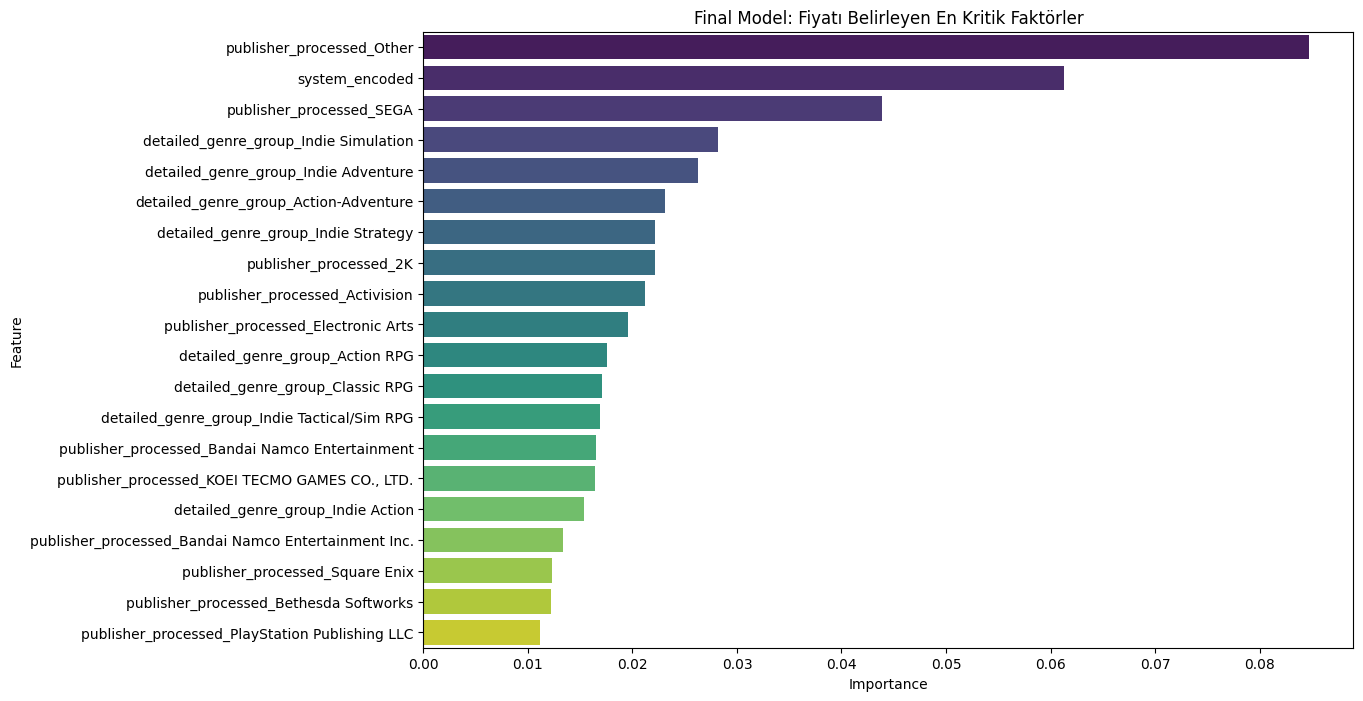

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': xgb_model_modern.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_imp_df.head(20), x='Importance', y='Feature', palette='viridis')
plt.title('Final Model: Fiyatı Belirleyen En Kritik Faktörler')
plt.show()



-gameplay_type sutunu kaldırılarak denendi. Düşüş yaşandı, kod silindi
-system_req kolonu kaldırılarak denendi, düşüş yaşandı, kod silindi


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

# 1. AYARLAR
candidate_days = [1400, 1425, 1435, 1440, 1445, 1450, 1460, 1461]
candidate_pubs = [415, 420, 422, 425, 427, 430, 435, 440, 445]

results = []
print(f"- TARAMA BAŞLIYOR: {len(candidate_days) * len(candidate_pubs)} Kombinasyon ---\n")

for days in candidate_days:
    for pub_count in candidate_pubs:
        try:

            temp = df[df['game_age_days'] <= days].copy()

            if len(temp) < 500: continue # oyun sayısı 500 altına düşüyorsa değerlendirmedik

            top_pubs = df.groupby('publisher_name')['recommendations_total'].sum().nlargest(pub_count).index
            temp['publisher_processed'] = temp['publisher_name'].apply(lambda x: x if x in top_pubs else 'Other')


            y = temp['mat_initial_price_usd']
            X = temp[['game_age_days', 'system_encoded', 'detailed_genre_group', 'gameplay_type', 'publisher_processed']]

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

            scaler = StandardScaler()
            encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

            X_train_final = np.hstack([
                scaler.fit_transform(X_train[['game_age_days', 'system_encoded']]),
                encoder.fit_transform(X_train[['detailed_genre_group', 'gameplay_type', 'publisher_processed']])
            ])

            X_test_final = np.hstack([
                scaler.transform(X_test[['game_age_days', 'system_encoded']]),
                encoder.transform(X_test[['detailed_genre_group', 'gameplay_type', 'publisher_processed']])
            ])

            model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
            model.fit(X_train_final, y_train)

            # E) Sonuç
            score = r2_score(y_test, model.predict(X_test_final))
            print(f"-> {days} Gün | {pub_count} Yayıncı | R2: {score:.4f}")

            results.append({'Days': days, 'Pub_Count': pub_count, 'R2': score, 'Data_Size': len(temp)})

        except Exception as e:
            print(f"Hata oluştu: {e}")

# KAPANIŞ RAPORU
print("\n" + "="*40)
if results:
    df_res = pd.DataFrame(results)
    best = df_res.loc[df_res['R2'].idxmax()]

    print("Sonuç")
    print(f"Gün Sınırı      : {int(best['Days'])}")
    print(f"Yayıncı Sayısı  : {int(best['Pub_Count'])}")
    print(f"R2 Skoru        : {best['R2']:.4f}")
    print(f"Oyun Sayısı     : {int(best['Data_Size'])}")
else:
    print("Hiçbir sonuç bulunamadı.")
print("="*40)

İdeal gün ve publisher sayısını  ulmak için çaprazlama kombinasyonları denedik ve 1400 gün ile 445 publisher en iyi sonucu veren kombinasyon oldu


In [67]:

FILTER_DAYS = 1400
TOP_PUB_COUNT = 445

print(f" MODELİN SON HALİ(Son {FILTER_DAYS} Gün, Top {TOP_PUB_COUNT} Yayıncı)")

df_final = df[df['game_age_days'] <= FILTER_DAYS].copy()

top_pubs = df.groupby('publisher_name')['recommendations_total'].sum().nlargest(TOP_PUB_COUNT).index
df_final['publisher_processed'] = df_final['publisher_name'].apply(lambda x: x if x in top_pubs else 'Other')


y = df_final['mat_initial_price_usd']
X = df_final[['game_age_days', 'system_encoded', 'detailed_genre_group', 'gameplay_type', 'publisher_processed']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

X_train_final = np.hstack([
    scaler.fit_transform(X_train[['game_age_days', 'system_encoded']]),
    encoder.fit_transform(X_train[['detailed_genre_group', 'gameplay_type', 'publisher_processed']])
])

X_test_final = np.hstack([
    scaler.transform(X_test[['game_age_days', 'system_encoded']]),
    encoder.transform(X_test[['detailed_genre_group', 'gameplay_type', 'publisher_processed']])
])

print("Model Eğitiliyor...")
final_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
final_model.fit(X_train_final, y_train)

# 5. SONUÇLAR
y_pred = final_model.predict(X_test_final)
print("-" * 40)
print(f"R2 SKORU (Başarı) : {r2_score(y_test, y_pred):.2f}")
print(f"ORTALAMA HATA     : {mean_absolute_error(y_test, y_pred):.2f} $")
print("-" * 40)



 MODELİN SON HALİ(Son 1400 Gün, Top 445 Yayıncı)
Model Eğitiliyor...


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


----------------------------------------
R2 SKORU (Başarı) : 0.63
ORTALAMA HATA     : 7.48 $
----------------------------------------


In [50]:
#Şimdi sonuçlarımızı görelim ve fiyat belirleyelim

def tahmin_et(publisher, genre, system_req, gameplay_type):
    try:
        pub_val = publisher if publisher in top_pubs else 'New Studio'

        inp_num = pd.DataFrame([[0, system_req]], columns=['game_age_days', 'system_encoded'])
        inp_cat = pd.DataFrame([[genre, gameplay_type, pub_val]], columns=['detailed_genre_group', 'gameplay_type', 'publisher_processed'])

        final_input = np.hstack([scaler.transform(inp_num), encoder.transform(inp_cat)])
        fiyat = final_model.predict(final_input)[0]


        print(f"🎮 {publisher:<10} ({pub_val}) | {genre:<15} | {gameplay_type:<13} | Sis: {system_req} -> 💰 {fiyat:.2f} $")
        return fiyat
    except:
        print("Hata: Girilen oyun türü veya özelliği veritabanında bulunamadı.")

# --- TESTLER ---
tahmin_et('Ubisoft', 'Action RPG', 3, 'Multiplayer only')
tahmin_et('Ubisoft', 'Action RPG', 3, 'Single-player only')

🎮 Ubisoft    (Ubisoft) | Action RPG      | Multiplayer only | Sis: 3 -> 💰 41.56 $
🎮 Ubisoft    (Ubisoft) | Action RPG      | Single-player only | Sis: 3 -> 💰 50.35 $


np.float32(50.35307)

In [51]:
tahmin_et('Steam-Lab', 'Indie Simulation', 2, 'Single-player only')
tahmin_et('Steam-Lab', 'Indie Simulation', 2, 'Multiplayer only')
tahmin_et('Ubisoft', 'Simulation', 3, 'Single-player only')
tahmin_et('Ubisoft', 'Simulation', 3, 'Multiplayer only')

🎮 Steam-Lab  (New Studio) | Indie Simulation | Single-player only | Sis: 2 -> 💰 19.20 $
🎮 Steam-Lab  (New Studio) | Indie Simulation | Multiplayer only | Sis: 2 -> 💰 14.70 $
🎮 Ubisoft    (Ubisoft) | Simulation      | Single-player only | Sis: 3 -> 💰 38.22 $
🎮 Ubisoft    (Ubisoft) | Simulation      | Multiplayer only | Sis: 3 -> 💰 33.87 $


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


np.float32(33.86951)

In [52]:
tahmin_et('Ubisoft', 'Action RPG', 3, 'Single-player')
tahmin_et('Rockstar Games', 'Action RPG', 3, 'Single-player')
tahmin_et('Rockstar Games', 'İndie', 1, 'Single-player')
tahmin_et('Ubisoft', 'Action RPG', 1, 'Single-player')


🎮 Ubisoft    (Ubisoft) | Action RPG      | Single-player | Sis: 3 -> 💰 47.03 $
🎮 Rockstar Games (Rockstar Games) | Action RPG      | Single-player | Sis: 3 -> 💰 53.18 $
🎮 Rockstar Games (Rockstar Games) | İndie           | Single-player | Sis: 1 -> 💰 29.79 $
🎮 Ubisoft    (Ubisoft) | Action RPG      | Single-player | Sis: 1 -> 💰 21.68 $


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


np.float32(21.679325)

Modelin son hali, modelimiz fiyat tahminlemesinin 63%ünü açıklayabiliyor. Farklı parametrelerle tahminlediğimiz fiyatlar yukarıda gözükmektedir.

Aşağıda rastgele 100 oyunla tahminlediğimiz fiyatlar karşılaştırılmıştır.

In [53]:

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

indexler = y_test.index

# Sonuçları koyacağımız boş bir tablo (DataFrame) oluşturuyoruz
sonuc_tablosu = pd.DataFrame()

sonuc_tablosu['Oyun Adi'] = df_final.loc[indexler, 'name']
sonuc_tablosu['Gercek Fiyat'] = y_test.values
sonuc_tablosu['Tahmin'] = y_pred

# Farklar(Gerçek - Tahmin)
sonuc_tablosu['Fark ($)'] = sonuc_tablosu['Gercek Fiyat'] - sonuc_tablosu['Tahmin']

# Yüzdelik fark
sonuc_tablosu['Fark %'] = (sonuc_tablosu['Gercek Fiyat'] - sonuc_tablosu['Tahmin']) / sonuc_tablosu['Gercek Fiyat']

# Hatanın eksi olmaması için mutlak değerini alıyoruz (Ortalama hesaplamak için lazım)
sonuc_tablosu['Mutlak Hata'] = sonuc_tablosu['Fark ($)'].abs()

# Rastgele 100 tane oyun seçiyoruz
rastgele_ornekler = sonuc_tablosu.sample(100)

# 100 satırın hepsini göstersin diye
pd.options.display.max_rows = 100

print("RASTGELE SEÇİLEN 100 OYUNUN DURUMU:")
print(rastgele_ornekler[['Oyun Adi', 'Gercek Fiyat', 'Tahmin', 'Fark ($)', 'Fark %']].round(2))

# Ortalama
ornek_hata = rastgele_ornekler['Mutlak Hata'].mean()

print("\n------------------------------------------------")
print("100 oyunluk örnekte ortalama hata:", round(ornek_hata, 2))
print("Genel Test Hatası (MAE):", round(mae, 2))

RASTGELE SEÇİLEN 100 OYUNUN DURUMU:
                                               Oyun Adi  Gercek Fiyat     Tahmin  Fark ($)  Fark %
3173                                              POOLS          9.79  21.770000    -11.98   -1.22
3040                                             GNOSIA         24.99  15.860000      9.13    0.37
2221                        Only Climb: Better Together          4.99  22.080000    -17.09   -3.42
3782                                       Dorfromantik         13.99  17.950001     -3.96   -0.28
3742                  Eiyuden Chronicle: Hundred Heroes         49.99  29.410000     20.58    0.41
1079                                            Copycat         14.99  13.240000      1.75    0.12
318                                           New Cycle         29.99  35.000000     -5.01   -0.17
3370                                       Realm of Ink         16.99  19.070000     -2.08   -0.12
1295                                    Monument Valley          7.99  19

Fena durmuyor sonuçlar. Bazı oyunlarda kötü tahminleme yapmışız fakat genel resim gerçek verilere yakın

Aşağıda da tür bazlı ortalama fiyatlarla tahminlediğimiz ortalama fiyatlarla kıyasladık

In [54]:

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

test_indexleri = y_test.index
test_turleri = df_final.loc[test_indexleri, 'detailed_genre_group']

tur_tablosu = pd.DataFrame()
tur_tablosu['Tur'] = test_turleri
tur_tablosu['Gercek'] = y_test.values.round()
tur_tablosu['Tahmin'] = y_pred.round()

tur_tablosu['Hata'] = (tur_tablosu['Gercek'] - tur_tablosu['Tahmin']).abs()

# GRUPLAMA
ozet_tablo = tur_tablosu.groupby('Tur').agg(
    Oyun_Sayisi   = ('Tur', 'count'),    # O türde kaç oyun tane var?
    Gercek_Fiyat  = ('Gercek', 'mean'),  # O türün piyasa ortalaması ne?
    Tahmin_Fiyat  = ('Tahmin', 'mean'),  # Biz ortalama kaç demişiz?
    Ortalama_Hata = ('Hata', 'mean')     # Ortalama kaç dolar yanılmışız?
)


ozet_tablo['Sapma'] = ozet_tablo['Gercek_Fiyat'] - ozet_tablo['Tahmin_Fiyat']

# Sıralama: En çok oyunu olan tür en tepede
ozet_tablo = ozet_tablo.sort_values(by='Oyun_Sayisi', ascending=False)
ozet_tablo["Tahmin_Fiyat"] = ozet_tablo["Tahmin_Fiyat"].round()
# Sonuçlar
pd.options.display.max_rows = 200 # Satırları gizleme, hepsini göster
print("\nTÜR BAZLI PERFORMANS KARNESİ")
print("===============================================================================================")
print(ozet_tablo.round(1))
print("===========================================================================================")
print(f"Toplam Oyun Sayısı               {tur_tablosu["Tur"].count()}")


TÜR BAZLI PERFORMANS KARNESİ
                        Oyun_Sayisi  Gercek_Fiyat  Tahmin_Fiyat  Ortalama_Hata  Sapma
Tur                                                                                  
Indie Tactical/Sim RPG           40          16.8          18.0            6.2   -1.1
Indie Simulation                 31          18.3          18.0            5.9    0.4
Indie Action RPG                 23          15.4          20.0            7.1   -4.5
Action                           22          36.4          31.0           11.3    5.1
Indie Action-Adventure           20          16.6          17.0            6.6   -0.1
Indie Strategy & Sim             20          16.6          18.0            7.6   -1.5
Action-Adventure                 18          47.7          50.0            6.9   -2.1
Strategy & Sim                   16          33.9          32.0            7.1    2.1
Indie Action                     15          20.9          18.0            5.0    2.7
Action RPG              

Tür bazlı ortalamaya baktığımızda da dah aaz oyun barındıran türlerin tahminleri daha fazla hata yüzdesine sahip

Bütün oyunların ortalama fiyatını sabit fiyat kabul etseydik (Base Model) modeliminiz karşısında nasıl bir performans gösterirdi?


In [55]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Ortalama fiyatı bütün test verilerine atıyoruz
avg_price = y_train.mean()
y_pred_base = np.full(len(y_test), avg_price)

# 2. Hata Hesaplamaları (Base vs XGBoost)
mae_base = mean_absolute_error(y_test, y_pred_base)
mae_xgb = mean_absolute_error(y_test, y_pred)

# 3. Ne kadar geliştirdik?
iyilesme_miktari = mae_base - mae_xgb
iyilesme_orani = (iyilesme_miktari / mae_base) * 100

# 4. Sonuçları Yazdır
print(f"{'MODEL':<25} {'HATA (MAE)':<15} {'R2 SKORU'}")
print("-" * 55)
print(f"{'Base Model (Ortalama)':<25} {round(mae_base)} $ {'':<8}   {round(r2_score(y_test, y_pred_base))}")
print(f"{'XGBoost (Senin Model)':<25} {mae_xgb:.2f} $ {'':<8} {r2_score(y_test, y_pred):.2f}")
print("-" * 55)

print(f"SONUÇ: Oortalama {iyilesme_miktari:.2f}$ daha doğru tahminledik.")
print(f"Modelimiz, ortalama almaya göre {round(iyilesme_orani)}% daha başarılı.")

MODEL                     HATA (MAE)      R2 SKORU
-------------------------------------------------------
Base Model (Ortalama)     13 $            0
XGBoost (Senin Model)     7.48 $          0.63
-------------------------------------------------------
SONUÇ: Oortalama 5.97$ daha doğru tahminledik.
Modelimiz, ortalama almaya göre 44% daha başarılı.


In [56]:


#Base model ortalaması
base_price = y_train.mean()


y_train_pred = final_model.predict(X_train_final)

df_train_res = pd.DataFrame({
    'Oyun İsmi': df_final.loc[y_train.index, 'name'],
    'Gerçek Fiyat': y_train.values,
    'Model Tahmin': y_train_pred,
    'Set Tipi': 'Eğitim (Train)'
})

y_test_pred = final_model.predict(X_test_final)

df_test_res = pd.DataFrame({
    'Oyun İsmi': df_final.loc[y_test.index, 'name'],
    'Gerçek Fiyat': y_test.values,
    'Model Tahmin': y_test_pred.round(),
    'Set Tipi': 'Test (Sınav)'
})

total_arena = pd.concat([df_train_res, df_test_res])
df_test_res["Model Tahmin"] = df_test_res["Model Tahmin"].round()

total_arena["Model Tahmin"] = total_arena["Model Tahmin"].round()
total_arena['Base Tahmin'] = base_price
total_arena['Base Hata'] = (total_arena['Gerçek Fiyat'] - total_arena['Base Tahmin']).abs()
total_arena['Model Hata'] = (total_arena['Gerçek Fiyat'] - total_arena['Model Tahmin']).abs()

# Kimin hatası daha küçükse o kazanır
total_arena['Kazanan'] = np.where(total_arena['Model Hata'] < total_arena['Base Hata'], 'SEN', 'BASE')

# 5. Sonuçları hesaplayalım
toplam_oyun = len(total_arena)
senin_zaferin = len(total_arena[total_arena['Kazanan'] == 'SEN'])
base_zafer = len(total_arena[total_arena['Kazanan'] == 'BASE'])
basari_orani = (senin_zaferin / toplam_oyun) * 100


# Ekrana yazdıralım
print("-" * 50)
print(f"TÜM VERİ RAPORU ({toplam_oyun} Oyun)")
print("-" * 50)
print(f"Modelin doğru tahmini : {senin_zaferin}")
print(f"Base modelin doğru tahmini   : {base_zafer}")
print(f"Başarı Oranı     : %{basari_orani:.2f}")
print("-" * 50)

# 6. Ezber kontrolü yapalım (Train ve Test farkı)
train_error = total_arena[total_arena['Set Tipi'] == 'Eğitim (Train)']['Model Hata'].mean()
test_error = total_arena[total_arena['Set Tipi'] == 'Test (Sınav)']['Model Hata'].mean()



--------------------------------------------------
TÜM VERİ RAPORU (1479 Oyun)
--------------------------------------------------
Modelin doğru tahmini : 1148
Base modelin doğru tahmini   : 331
Başarı Oranı     : %77.62
--------------------------------------------------


Özetle modelimiz base modelden daha başarılı. Test verilerinde modelimizi test ettiğimizde model base modele kıyasla daha fazla oyunu tahmin edebiliyor

Aşağıda da base model ile bizim modelimizin hata dağılımlarını inceleyeceğiz.

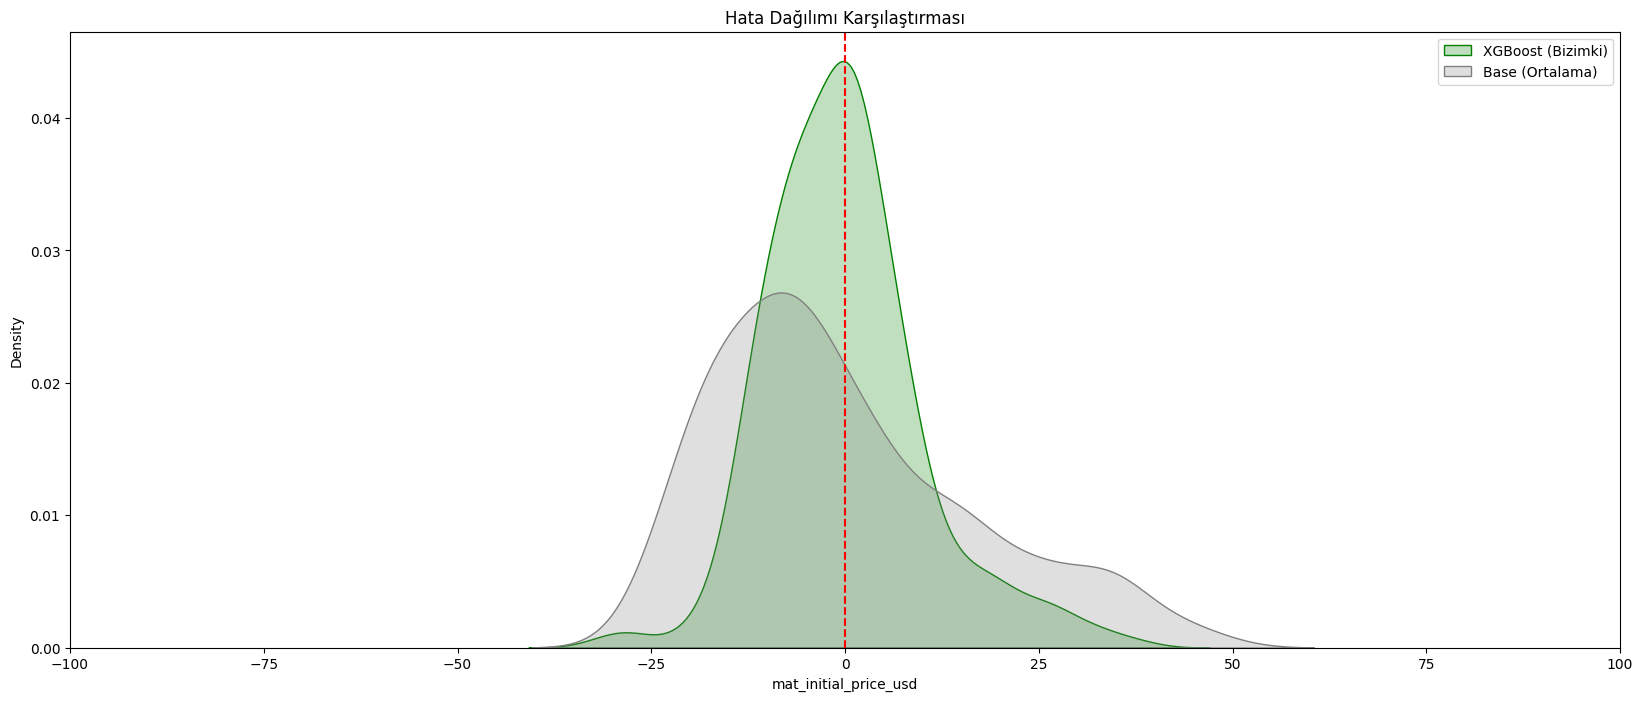

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 8))

# Hata Dağılımlarını Gerçek - Tahmin
sns.kdeplot(y_test - y_pred, fill=True, color='green', label='XGBoost (Bizimki)')
sns.kdeplot(y_test - y_pred_base, fill=True, color='gray', label='Base (Ortalama)')

# Referans Çizgisi ve Ayarlar
plt.axvline(0, color='red', linestyle='--') # Tam 0 noktası (Hatasızlık)
plt.xlim(-100, 100)
plt.title('Hata Dağılımı Karşılaştırması')
plt.legend()

plt.show()

Modelimiz gerçek fiyatlara daha yakın duruyor. Base model hata yoğunluğu modelimizden fazla.

Aynı grafiği sistem gereksinimlerine göre inceledik

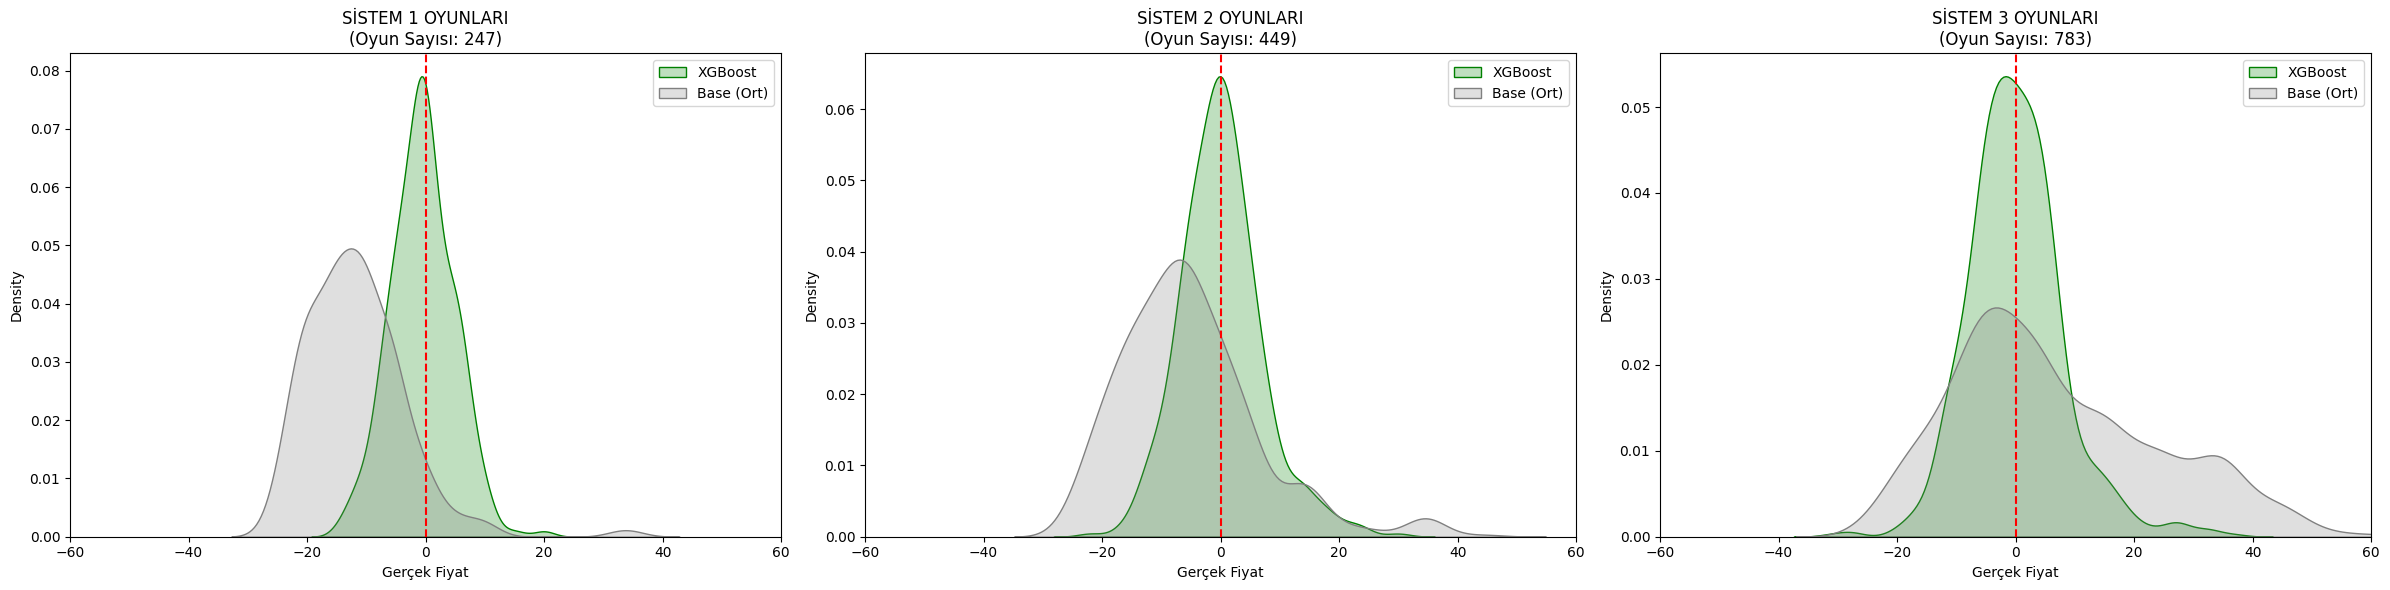

In [58]:

plot_data = total_arena.copy()

plot_data['Sistem'] = df_final.loc[total_arena.index, 'system_encoded']

ortalama_fiyat = y_train.mean()

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# SİSTEM 1 İÇİN GRAFİK
subset1 = plot_data[plot_data['Sistem'] == 1]
hata_xgb1 = subset1['Gerçek Fiyat'] - subset1['Model Tahmin']
hata_base1 = subset1['Gerçek Fiyat'] - ortalama_fiyat

sns.kdeplot(hata_xgb1, ax=axes[0], fill=True, color='green', label='XGBoost')
sns.kdeplot(hata_base1, ax=axes[0], fill=True, color='gray', label='Base (Ort)')
axes[0].set_title(f"SİSTEM 1 OYUNLARI\n(Oyun Sayısı: {len(subset1)})")
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_xlim(-60, 60)
axes[0].legend()

# SİSTEM 2 İÇİN GRAFİK
subset2 = plot_data[plot_data['Sistem'] == 2]
hata_xgb2 = subset2['Gerçek Fiyat'] - subset2['Model Tahmin']
hata_base2 = subset2['Gerçek Fiyat'] - ortalama_fiyat

sns.kdeplot(hata_xgb2, ax=axes[1], fill=True, color='green', label='XGBoost')
sns.kdeplot(hata_base2, ax=axes[1], fill=True, color='gray', label='Base (Ort)')
axes[1].set_title(f"SİSTEM 2 OYUNLARI\n(Oyun Sayısı: {len(subset2)})")
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlim(-60, 60)
axes[1].legend()

# SİSTEM 3 İÇİN GRAFİK
subset3 = plot_data[plot_data['Sistem'] == 3]
hata_xgb3 = subset3['Gerçek Fiyat'] - subset3['Model Tahmin']
hata_base3 = subset3['Gerçek Fiyat'] - ortalama_fiyat

sns.kdeplot(hata_xgb3, ax=axes[2], fill=True, color='green', label='XGBoost')
sns.kdeplot(hata_base3, ax=axes[2], fill=True, color='gray', label='Base (Ort)')
axes[2].set_title(f"SİSTEM 3 OYUNLARI\n(Oyun Sayısı: {len(subset3)})")
axes[2].axvline(0, color='red', linestyle='--')
axes[2].set_xlim(-60, 60)
axes[2].legend()

plt.tight_layout()
plt.show()

Hem sistem gereksinimi hem de türlere göre dağılımını inceledik

In [59]:


pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

df_analiz = total_arena.copy()

df_analiz['Ham_Tür'] = df_final.loc[total_arena.index, 'detailed_genre_group']
df_analiz['Sistem'] = df_final.loc[total_arena.index, 'system_encoded']

sayilar = df_analiz['Ham_Tür'].value_counts()
df_analiz['Tür'] = df_analiz['Ham_Tür'].apply(lambda x: f"{x} ({sayilar[x]})")


tablo = df_analiz.groupby(['Tür', 'Sistem'])[['Gerçek Fiyat', 'Model Tahmin']].mean()
tablo["Model Tahmin"] = tablo["Model Tahmin"].round()

0
tablo['% Fark'] = ((tablo['Model Tahmin'] - tablo['Gerçek Fiyat']) / tablo['Gerçek Fiyat']) * 100

final_tablo = tablo.unstack()

print("-" * 70)
print("SİSTEMLERE GÖRE DETAYLI RAPOR (Gerçek vs Model)")
print("-" * 70)
print(final_tablo.round(1).fillna("-"))
print("-"*70)
print(f"Toplam Oyun Sayısı :{len(df_analiz)}")

----------------------------------------------------------------------
SİSTEMLERE GÖRE DETAYLI RAPOR (Gerçek vs Model)
----------------------------------------------------------------------
                               Gerçek Fiyat             Model Tahmin             % Fark             
Sistem                                    1     2     3            1     2     3      1     2      3
Tür                                                                                                 
Action (88)                            22.2  27.2  41.3         23.0  25.0  38.0    3.5  -8.1   -8.0
Action RPG (103)                       14.0  38.4  44.3         18.0  37.0  44.0   28.7  -3.8   -0.8
Action-Adventure (98)                  24.0  30.3  44.7         24.0  29.0  45.0    0.0  -4.4    0.6
Adventure (49)                         22.1  21.1  32.9         22.0  22.0  32.0   -0.6   4.1   -2.6
Casual (4)                              2.5  10.0  10.0          6.0  10.0  24.0  141.0   0.1  140.2
Cl

Şİmdi türlere göre base modelden sistem gereksinimlerine göre incelediğimizde ne kadar iyi olduğumuzu heat mapte görelim


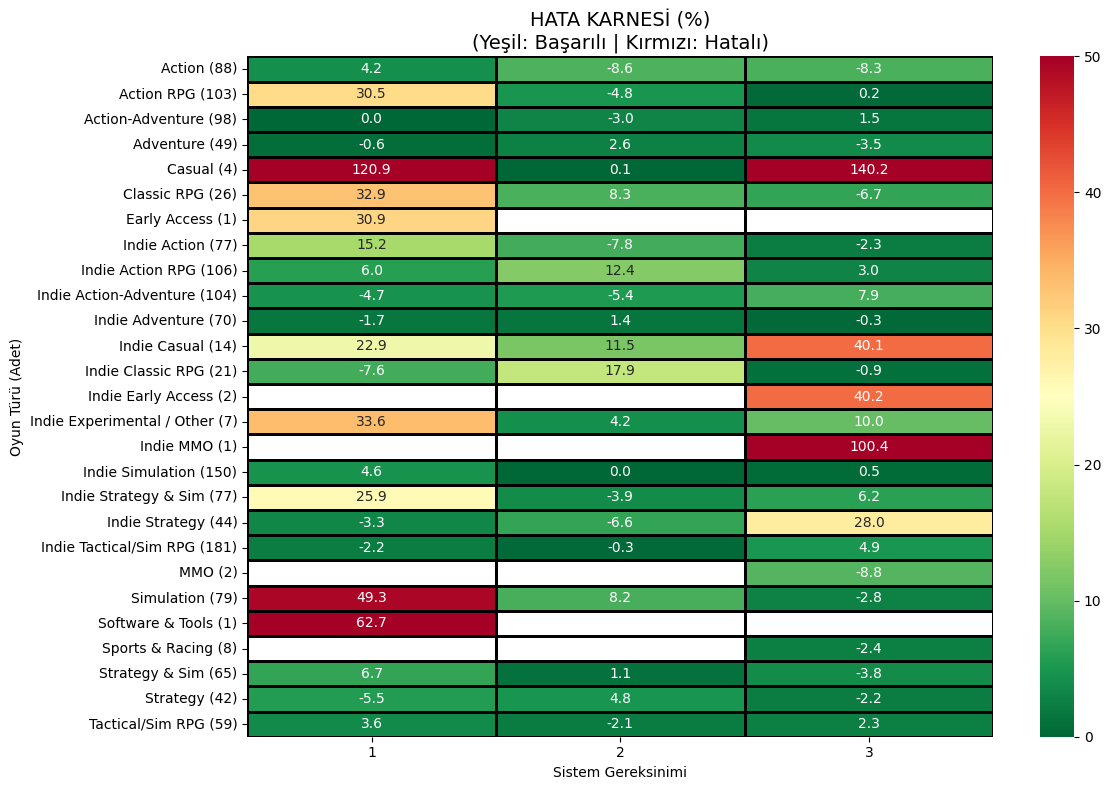

In [60]:
ozet = df_analiz.groupby(['Tür', 'Sistem'])[['Gerçek Fiyat', 'Model Tahmin']].mean().unstack()
hata_matrisi = ((ozet['Model Tahmin'] - ozet['Gerçek Fiyat']) / ozet['Gerçek Fiyat']) * 100

plt.figure(figsize=(12, 8))
sns.heatmap(
    hata_matrisi.abs(),
    annot=hata_matrisi,
    fmt=".1f",
    cmap="RdYlGn_r",
    vmin=0, vmax=50,
    linewidths=1, linecolor='black'
)
plt.title('HATA KARNESİ (%)\n(Yeşil: Başarılı | Kırmızı: Hatalı)', fontsize=14)
plt.xlabel('Sistem Gereksinimi')
plt.ylabel('Oyun Türü (Adet)')
plt.tight_layout()
plt.show()

Oyun sayısı azaldıkça ve sistem gereksinimi düştükçe modelimiz başarısızlaşıyor fakat orta ve yüksek sistem gereksimli ve daha fazla oyuna sahip türlerde modelimiz gayet tutarlı.